In [ ]:
# Lab4 Decision Trees

A Decision Tree is a model used for both classification and regression tasks. It's a tree-like structure that represents decisions and their possible consequences, including chance event outcomes, resource costs, and utility. Here's a breakdown of its components and how it works:

### Components
Root Node: Represents the entire dataset, which then gets divided into two or more homogeneous sets.

Splitting: It's the process of dividing a node into two or more sub-nodes based on certain conditions.

Decision Node: When a sub-node splits into further sub-nodes, it's called a decision node.

Leaf/Terminal Node: Nodes that do not split further, which represents a decision or classification.

Pruning: The process of removing sub-nodes from a decision node, this can be done to reduce the complexity of the model and avoid overfitting.

### How it Works
Selection of the Best Attribute: Using certain criteria, such as information gain or Gini impurity, the best attribute is selected to split the data.

Splitting: The dataset is split into subsets based on the attribute value. This process is performed recursively.

Stopping Criteria: The recursion ends when one of the conditions is met, for example, when all instances in a node belong to the same class, no attribute is left to split, or the tree has reached a maximum specified depth.

Classification/Regression: For classification tasks, the tree predicts the class of an instance by following the decisions in the tree from the root to a leaf. For regression tasks, it predicts the value.

Decision Trees are popular due to their simplicity and interpretability. You can easily understand and visualize how decisions are made, making them a good starting point for many Machine Learning tasks. However, they are prone to overfitting, especially with complex datasets. Techniques like pruning and ensemble methods such as Random Forests are often used to mitigate this issue.

In [217]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

#################################
# Implementation

# Added a node id to make it easy to visulize the tree
gid = 0

#################################
# Genereic Node
#
# - Leaf node if valu is Not None
# - 
class Node:
    def __init__(self,feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature # The deciding feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
        global gid
        gid = gid + 1
        self.id = gid
        
    def is_leaf_node(self):
        return self.value is not None


#################################
# Decision Tree
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
       









In [218]:
#################################
# Load data and run modell

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print("-------- DATA -------")
print(f"X_train: {X_train.shape} - {X_train.dtype}")
print(f"y_train: {y_train.shape} - {X_train.dtype}")
print(f"X_test: {X_test.shape} - {X_train.dtype}")
print(f"y_test: {y_test.shape} - {X_train.dtype}")
print("----------------------")
np.set_printoptions(precision=4,suppress=True)
print(f"X_train: {X_train[:4]}\n")
print(f"y_train: {y_train[:4]}\n")
print(f"Number of positives in the dataset {np.count_nonzero(y_train==1)}\n")
print("----------------------")

clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print(acc)

-------- DATA -------
X_train: (455, 30) - float64
y_train: (455,) - float64
X_test: (114, 30) - float64
y_test: (114,) - float64
----------------------
X_train: [[ 12.88    18.22    84.45   493.1      0.1218   0.1661   0.0483   0.053
    0.1709   0.0725   0.4426   1.169    3.176   34.37     0.0053   0.0233
    0.014    0.0124   0.0182   0.0033  15.05    24.37    99.31   674.7
    0.1456   0.2961   0.1246   0.1096   0.2582   0.0889]
 [ 11.13    22.44    71.49   378.4      0.0957   0.0819   0.0482   0.0226
    0.203    0.0655   0.28     1.467    1.994   17.85     0.0035   0.0305
    0.0345   0.0102   0.0291   0.0047  12.02    28.26    77.8    436.6
    0.1087   0.1782   0.1564   0.0641   0.3169   0.0803]
 [ 12.63    20.76    82.15   480.4      0.0993   0.1209   0.1065   0.0602
    0.1735   0.0707   0.3424   1.803    2.711   20.48     0.0129   0.0404
    0.051    0.023    0.0214   0.0059  13.33    25.47    89.     527.4
    0.1287   0.225    0.2216   0.1105   0.2226   0.0849]
 [ 12.68   

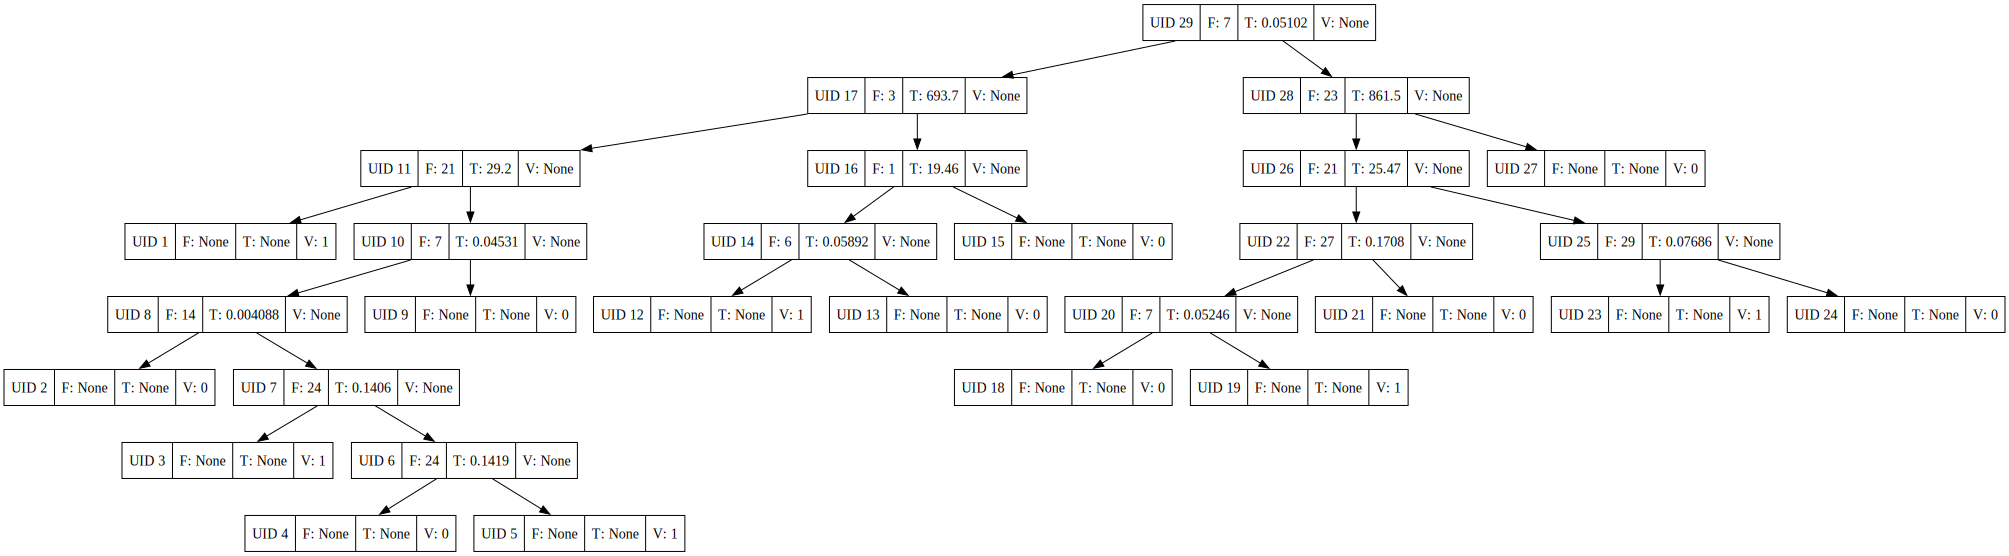

In [240]:
########
# What does the tree look like
from graphviz import Digraph

def add_nodes_edges(node, parent_name, graph=None):
    
    if graph is None:
        graph = Digraph()
        graph.node(name=str(parent_name), label=str(f"UID {node.id} | F: {tree.feature} | T: {tree.threshold} | V: {tree.value}" ),shape='record')

    for child in [node.left,node.right]:
        
        if (child is not None):
            graph.node(name=str(child.id), label=str(f"UID {child.id} |F: {child.feature} | T: {child.threshold} | V: {child.value}" ),shape='record')
            graph.edge(parent_name,str(child.id))  
            
            add_nodes_edges(child,str(child.id),graph)
    
    return graph

    
root = clf.root
dot = add_nodes_edges(root, str(root.id))
dot


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic_data = pd.read_csv(url)

# Handle missing values
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)
titanic_data.drop(['Cabin'], axis=1, inplace=True)

# Convert categorical features to numerical
titanic_data['Sex'] = LabelEncoder().fit_transform(titanic_data['Sex'])
titanic_data = pd.get_dummies(titanic_data, columns=['Embarked'], drop_first=True)

# Select relevant features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']
X = titanic_data[features]
y = titanic_data['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Titanic Survival Prediction')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [2]:
python -m pip install seaborn

SyntaxError: invalid syntax (2709203213.py, line 1)